# Non-Interactive PSF photometry using Simulated NIRCam Image

This notebook was contributed by Matteo Correnti, which some edits by Pey Lian Lim and inputs from Erik Tollerud.

Its goal is to perform PSF photometry on simulated JWST NIRCam image for a "crowded" field based on use case laid out in https://outerspace.stsci.edu/display/JWSTDATF/JWST+Data+Analysis+Tool+Use+Case+for+crowded+field+imaging .

Workflow:

* Use `photutils` to find stars in a given image.
* Circle the stars on the image.
* For each star found, make a cutout image.
* Display the cutouts for selection.
* Select a subset of the stars based on cutouts.
* Use the selection to build a PSF.
* Subtract PSF from image (a sub-image is used here to shorten run time).
* Display residual image and compare it to original sub-image.
* User may repeat the steps above until PSF is deemed satisfactory.
* Save out the final selection to a table file.

Future work:

* Repeat for the same field in a different filter.
* Use photometry results from both filters to build a CMD.

In [1]:
import os
import sys

import numpy as np

from astropy import units as u
from astropy.table import Table
from astropy.io import fits
from astropy import wcs

%matplotlib inline
from matplotlib import style, pyplot as plt

plt.rcParams['image.cmap'] = 'viridis'
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['axes.prop_cycle'] = style.library['seaborn-deep']['axes.prop_cycle']
plt.rcParams['figure.figsize'] = (14, 14)
plt.rcParams['axes.titlesize'] =  plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] =  plt.rcParams['ytick.labelsize'] = 14

plt.rcParams['image.interpolation'] = 'nearest'

Input file can be downloaded from https://stsci.app.box.com/s/1jp2g3uau0cgo0eq9uan3clr5rxjytt9 . Ask Matteo Correnti for permission.

In [4]:
im1fn = 'V1069002001P000000000110n_A2_F200W_cal.fits'

im1f = fits.open(im1fn)
data = im1f[1].data
im1h = im1f[1].header
im1wcs = wcs.WCS(im1h)

# This sub-image is used to generate residual image later.
# The only reason this is done is to speed things up at
# the prototyping stage.
data1 = data[0:200,0:200]

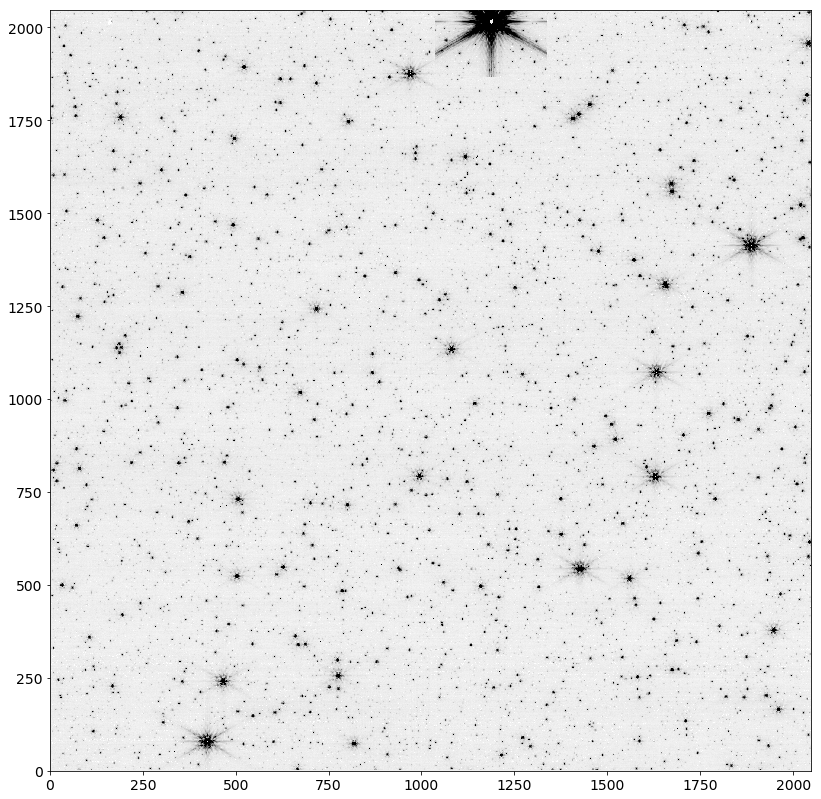

In [5]:
from astropy.visualization import (ZScaleInterval, SqrtStretch, ImageNormalize)
from astropy.visualization import simple_norm

norm = simple_norm(data, 'sqrt', percent=99.)

plt.figure(figsize=(14,14))
plt.imshow(data, norm=norm, cmap = 'Greys')

In [9]:
from photutils import find_peaks
from photutils.centroids import centroid_2dg

# Find the stars in the whole image.
peaks_tbl = find_peaks(data, threshold=75, box_size=75, centroid_func=centroid_2dg)
peaks_tbl['peak_value'].info.format = '%.8g'

print(len(peaks_tbl))
print(peaks_tbl[:10])

349
x_peak y_peak peak_value     x_centroid          y_centroid     
------ ------ ---------- ------------------ --------------------
   665      4  361.93878  666.0552435322816 -0.21515547565424153
  1575      6  86.846886 1575.6256358751566    6.783012876827686
  1831     14  211.34196 1830.9447410756625   14.404077728961065
   398     17   110.0424  398.2843689354262   16.725634239071557
  1325     18  96.866768 1325.2157782875024   17.989053097991963
  1652     25  76.919403 1650.9359607983588    60.91468978502665
  1067     36    138.356 1066.9884905176182    35.72479201706073
  1213     42  439.62793 1213.2603686813543   41.997141666629496
   906     44   196.6805  906.2420413142837   43.732172065036096
  1930     67  280.50177 1930.0050386910998    67.44105477828634


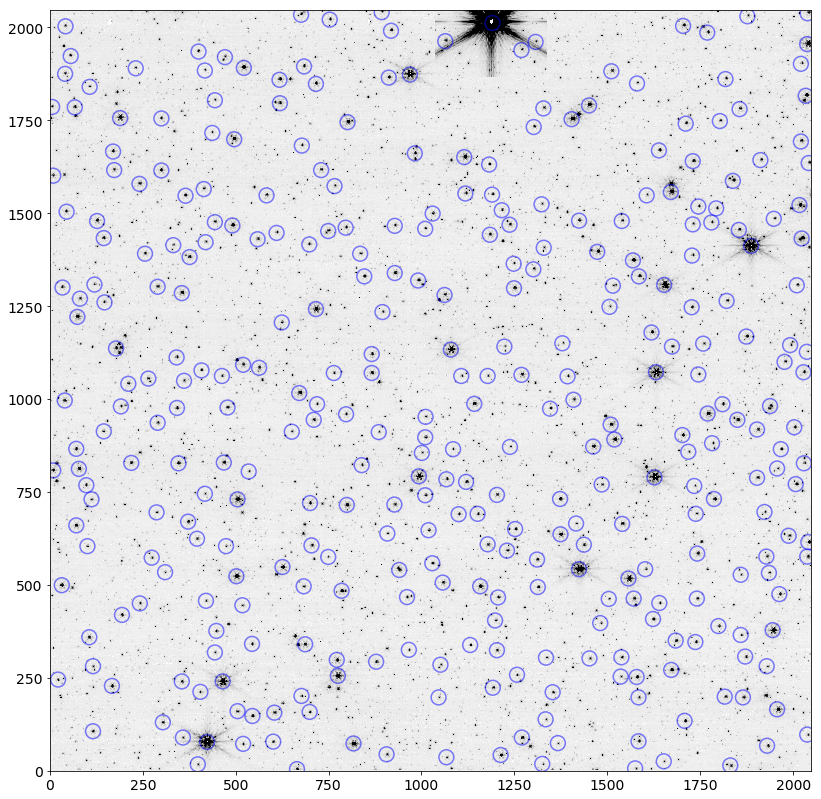

In [11]:
from photutils import CircularAperture

# Show the stars found on the image.
positions = (peaks_tbl['x_peak'], peaks_tbl['y_peak'])
apertures = CircularAperture(positions, r=20.)
plt.figure(figsize=(14,14))
plt.imshow(data, norm=norm, cmap='Greys')
apertures.plot(color='blue', lw=1.5, alpha=0.5)

# Notes from Matteo

For the interactive version of this notebook, I would like to:

* zoom on the image
* select/deselect a star
* derive parameters - first step in cleaning the catalog of stars selected for building the PSF

In [12]:
from astropy.table import Table

# This is required by photutils, which is weird.
# Opened issue at https://github.com/astropy/photutils/issues/800
stars_tbl = Table()
stars_tbl['x'] = peaks_tbl['x_peak']
stars_tbl['y'] = peaks_tbl['y_peak']

In [13]:
from astropy.stats import sigma_clipped_stats

# Simple background subtraction.
mean_val, median_val, std_val = sigma_clipped_stats(data, sigma=2.,
                                                    iters=None)
data_no_bg = data - median_val

In [14]:
from astropy.nddata import NDData

# Need to put array in NDData container for the next step.
nddata = NDData(data=data_no_bg)

In [15]:
from photutils.psf import extract_stars

# Extract the stars into cutouts for PSF building.
stars = extract_stars(nddata, stars_tbl, size=25)

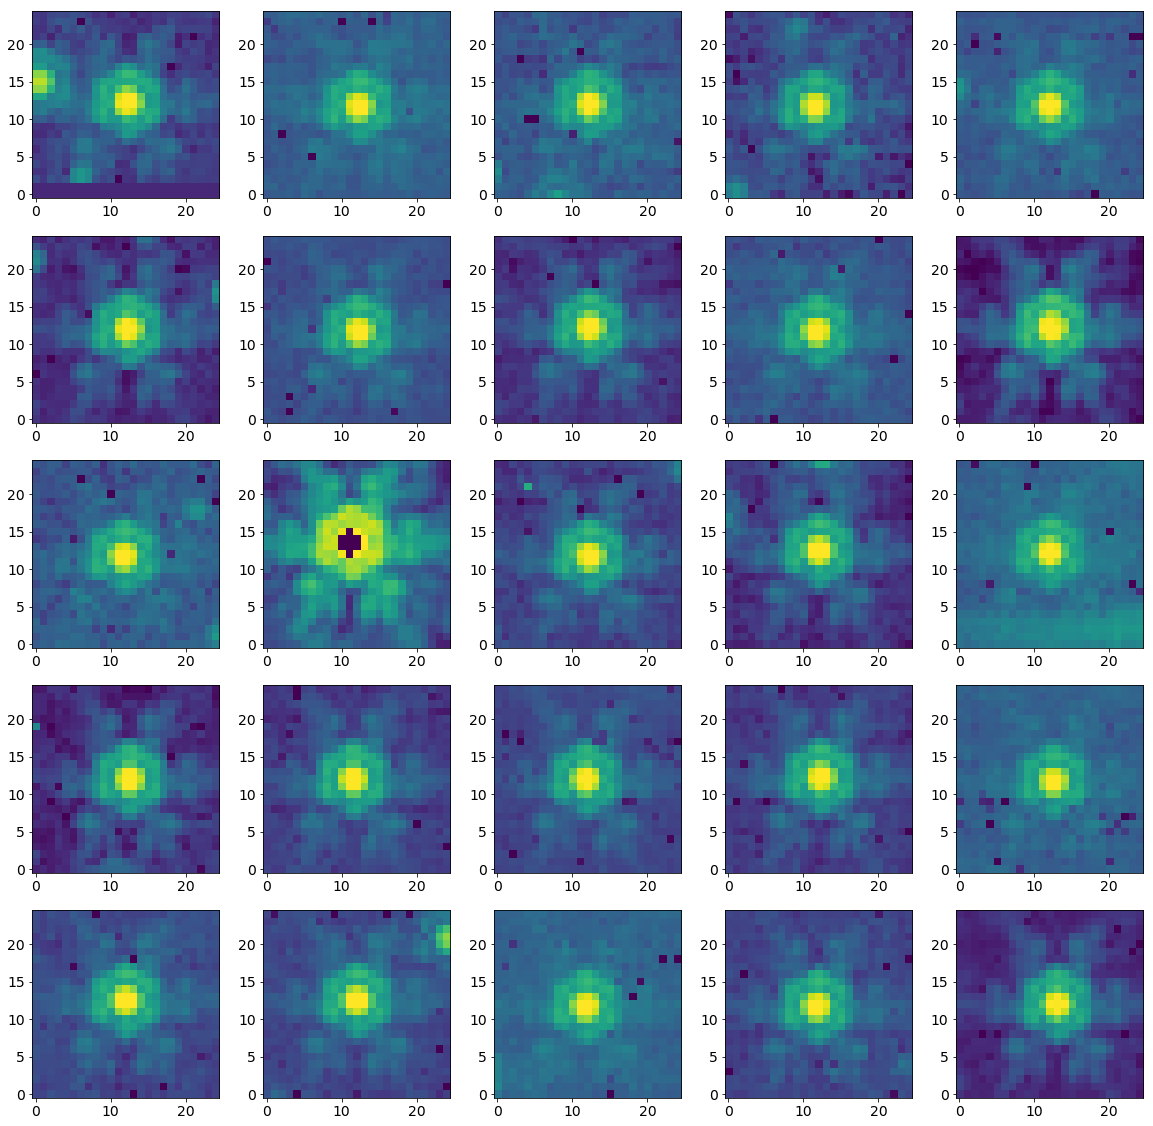

In [16]:
import matplotlib.pyplot as plt
from astropy.visualization import simple_norm

nrows = 5
ncols = 5
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20),
                       squeeze=True)
ax = ax.ravel()

# Non-interactive display of the cutouts.
for i in range(nrows*ncols):
    norm = simple_norm(stars[i], 'log', percent=99.)
    ax[i].imshow(stars[i], norm=norm, origin='lower', cmap='viridis')

# Notes from Matteo

For the interactive version of this notebook, I would like to:

* show in a GUI each star individually
* select stars to keep and to discard 

In [17]:
from photutils import EPSFBuilder

# Build the ePSF from stars selected above.
epsf_builder = EPSFBuilder(oversampling=4, maxiters=3,
                           progress_bar=False)
epsf, fitted_stars = epsf_builder(stars)

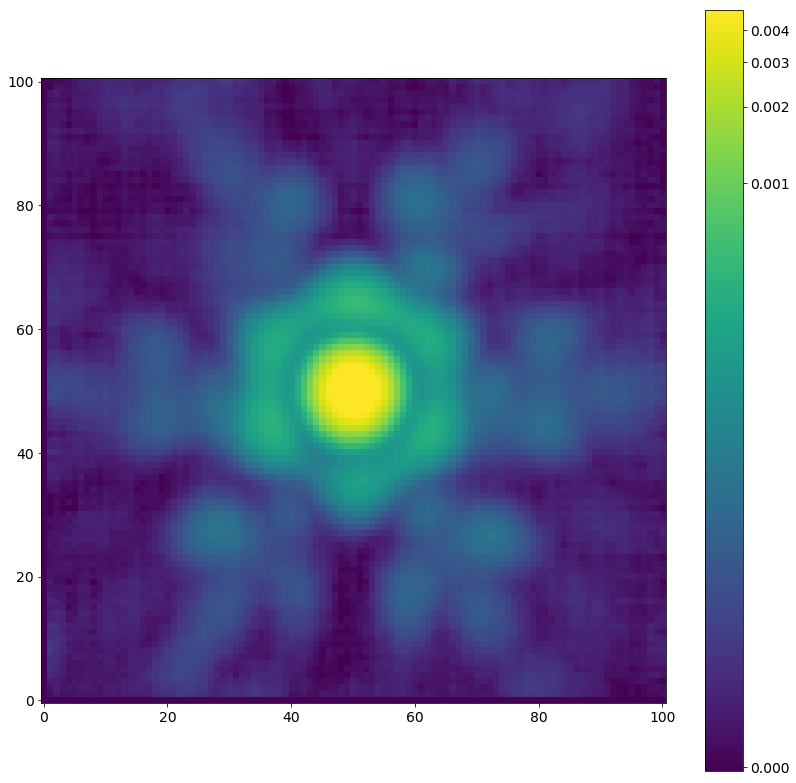

In [18]:
import matplotlib.pyplot as plt
from astropy.visualization import simple_norm

# Display the PSF.
plt.figure(figsize=(14,14))
norm = simple_norm(epsf.data, 'log', percent=99.)
plt.imshow(epsf.data, norm=norm, origin='lower', cmap='viridis')
plt.colorbar()

In [23]:
from astropy.stats import gaussian_sigma_to_fwhm

# This is not really needed. For informational purpose only.
sigma_psf = 1.25
fwhm = sigma_psf * gaussian_sigma_to_fwhm
print(fwhm)

2.9435250562886868


In [68]:
from photutils.detection import DAOStarFinder, IRAFStarFinder
from photutils.psf import DAOGroup
from photutils.psf import IntegratedGaussianPRF
from photutils.background import MMMBackground
from photutils.background import MADStdBackgroundRMS
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.stats import gaussian_sigma_to_fwhm

sigma_psf = 1.25

bkgrms = MADStdBackgroundRMS()

std = bkgrms(data)

iraffind = IRAFStarFinder(threshold=10*std,
                          fwhm=sigma_psf*gaussian_sigma_to_fwhm,
                          minsep_fwhm=0.01, roundhi=1.0, roundlo=-1.0,
                          sharplo=0.30, sharphi=1.40)

daogroup = DAOGroup(2.0*sigma_psf*gaussian_sigma_to_fwhm)

mmm_bkg = MMMBackground()

psf_model = epsf.copy()

fitter = LevMarLSQFitter()

In [69]:
from photutils.psf import IterativelySubtractedPSFPhotometry

# Subtract PSF to get residual image.
photometry = IterativelySubtractedPSFPhotometry(finder=iraffind, group_maker=daogroup,
                                                bkg_estimator=mmm_bkg, psf_model=psf_model,
                                                fitter=LevMarLSQFitter(),
                                                niters=2, fitshape=(11,11),
                                                aperture_radius=5)
result_tab = photometry(data1)
residual_image = photometry.get_residual_image()

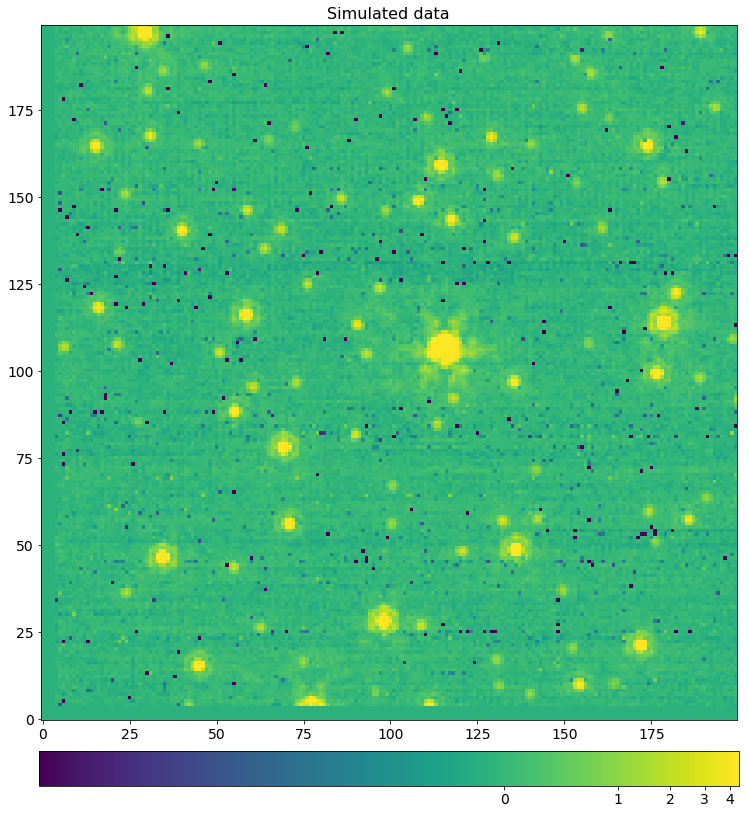

In [70]:
# Display the sub-image.
plt.figure(figsize=(14,14))
norm = simple_norm(data1, 'log', percent=99.)

plt.imshow(data1, norm=norm, origin='lower', cmap='viridis')
plt.title('Simulated data')
plt.colorbar(orientation='horizontal', fraction=0.046, pad=0.04)

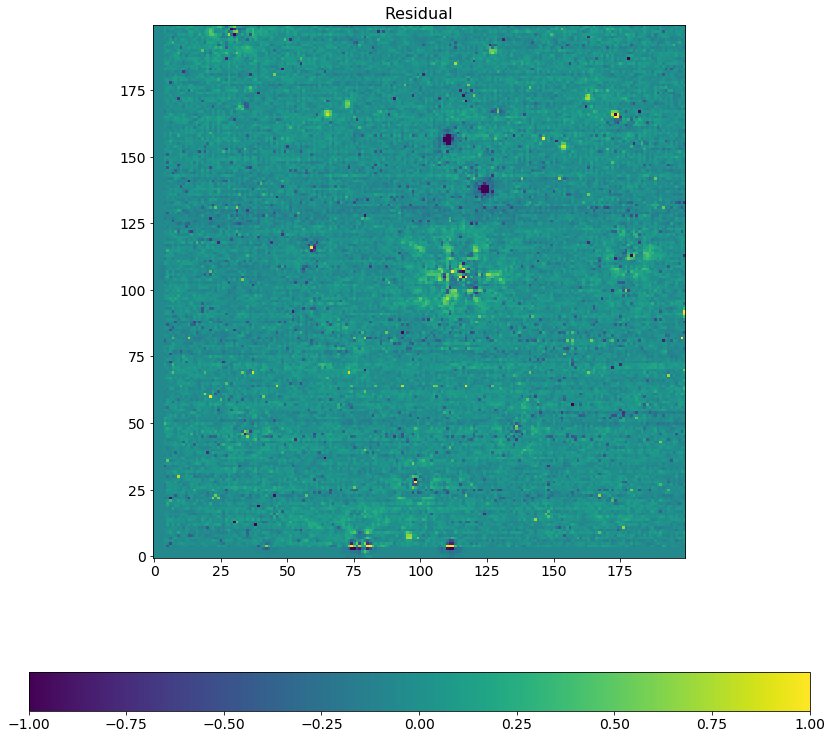

In [71]:
# Display the residual image.
plt.figure(figsize=(14, 14))
plt.imshow(residual_image, vmin=-1, vmax=1)
plt.title('Residual')
plt.colorbar(orientation='horizontal')

In [72]:
import numpy as np
from astropy.stats import biweight_location

# Print some stats from residual image.
print(np.median(residual_image))  
print(biweight_location(residual_image))

-0.0028879107
-0.0011251426498791659


# Notes from Matteo

In the interactive version of this notebook, I would like:

* GUI with two/three panels showing image, residual, (uncertiainties later) using ipywidget (in the notebook itself instead of two ginga panels).
* The two panels are linked and you can zoom and pan 

In [43]:
# PSF photometry result using sub-image.
result_tab.sort('id')
result_tab

x_0,x_fit,y_0,y_fit,flux_0,flux_fit,id,group_id,flux_unc,x_0_unc,y_0_unc,iter_detected
float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,int32
41.99585535667646,42.025967638958775,4.335121100590291,4.2979231254117005,3.949590542913997,122.95001973334492,1,1,8.970507370470008,0.10184562892381956,0.09687559529683937,1
110.80255655826656,111.24776491864127,0.4775797413423559,2.4176731488473826,-7.399748311662522,-130.86102428297602,1,1,0.0,0.0,0.0,2
74.02712716876762,74.78230353506011,4.015707020807916,2.314055731091871,-6.643178380379121,-66.09149651825076,2,2,5e-324,5e-324,5e-324,2
74.60089294131342,74.49352105812194,4.250560970206124,4.497621607899568,59.90481476757391,324.5806275563667,2,2,8.74e-322,8.74e-322,8.74e-322,1
80.83170763819926,79.89294559206863,4.0578528635080655,2.591830322420612,-5.802779227197255,-43.71990121348655,3,2,0.0,0.0,0.0,2
79.47439952655247,79.81839548494207,4.341684294730105,4.546813283239787,64.0252733032342,406.901366909866,3,2,8.94e-322,8.94e-322,8.94e-322,1
76.17589687569998,77.48185020000571,4.688191673507164,2.5546777371894733,-8.49542892653306,-48.49581145565258,4,2,0.0,0.0,0.0,2
111.1998767764823,111.25451840607928,4.295625644130798,4.288382112284959,26.733916364132043,614.7982005329409,4,3,28.743910646891706,0.06215475814261076,0.0618805899784203,1
79.16643779182843,80.53526383080123,4.710145604500959,8.013716585268677,-7.103219445063224,5.484852895395601,5,2,0.0,0.0,0.0,2
